In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [ ]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform, batch_size=64)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, latent_size)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 256)
        self.fc2 = nn.Linear(256, 28*28)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        return x

In [ ]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = 0.    
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
             
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        h = self.E(x)
        self.data_rho = h.mean(0)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):
        
        size = self.data_rho.shape[0]
        rho_vec = rho * torch.ones(size)
        
        l1_loss = nn.L1Loss()
        self._rho_loss = l1_loss(self.data_rho, rho_vec)
        
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss
   
   

In [5]:
models = {'64': Net(64)}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [6]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data) + rho_loss
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [7]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'pho_loss: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    pho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, size_average=False).item() # sum up batch loss
                pho_loss[k] += m.rho_loss(rho, size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        pho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], pho_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], pho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [8]:
for epoch in range(1, 101):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 64: 0.940790
Train Epoch: 1 [12800/50000 (26%)]	Losses 64: 0.283114
Train Epoch: 1 [25600/50000 (51%)]	Losses 64: 0.222566
Train Epoch: 1 [38400/50000 (77%)]	Losses 64: 0.182504
Train Epoch: 1 [12512/50000 (100%)]	Losses 64: 0.155343
Test set:
64: loss: 0.1532	pho_loss: 0.0000

Train Epoch: 2 [0/50000 (0%)]	Losses 64: 0.143087
Train Epoch: 2 [12800/50000 (26%)]	Losses 64: 0.132384
Train Epoch: 2 [25600/50000 (51%)]	Losses 64: 0.116795
Train Epoch: 2 [38400/50000 (77%)]	Losses 64: 0.114464
Train Epoch: 2 [12512/50000 (100%)]	Losses 64: 0.122317
Test set:
64: loss: 0.1076	pho_loss: 0.0000

Train Epoch: 3 [0/50000 (0%)]	Losses 64: 0.101593
Train Epoch: 3 [12800/50000 (26%)]	Losses 64: 0.100035
Train Epoch: 3 [25600/50000 (51%)]	Losses 64: 0.100459
Train Epoch: 3 [38400/50000 (77%)]	Losses 64: 0.100058
Train Epoch: 3 [12512/50000 (100%)]	Losses 64: 0.077081
Test set:
64: loss: 0.0865	pho_loss: 0.0000

Train Epoch: 4 [0/50000 (0%)]	Losses 64: 0.092338
Tr

Train Epoch: 26 [12512/50000 (100%)]	Losses 64: 0.028180
Test set:
64: loss: 0.0269	pho_loss: 0.0000

Train Epoch: 27 [0/50000 (0%)]	Losses 64: 0.027293
Train Epoch: 27 [12800/50000 (26%)]	Losses 64: 0.026815
Train Epoch: 27 [25600/50000 (51%)]	Losses 64: 0.025656
Train Epoch: 27 [38400/50000 (77%)]	Losses 64: 0.024601
Train Epoch: 27 [12512/50000 (100%)]	Losses 64: 0.027278
Test set:
64: loss: 0.0260	pho_loss: 0.0000

Train Epoch: 28 [0/50000 (0%)]	Losses 64: 0.026772
Train Epoch: 28 [12800/50000 (26%)]	Losses 64: 0.027186
Train Epoch: 28 [25600/50000 (51%)]	Losses 64: 0.024641
Train Epoch: 28 [38400/50000 (77%)]	Losses 64: 0.022805
Train Epoch: 28 [12512/50000 (100%)]	Losses 64: 0.021637
Test set:
64: loss: 0.0259	pho_loss: 0.0000

Train Epoch: 29 [0/50000 (0%)]	Losses 64: 0.026963
Train Epoch: 29 [12800/50000 (26%)]	Losses 64: 0.026751
Train Epoch: 29 [25600/50000 (51%)]	Losses 64: 0.024051
Train Epoch: 29 [38400/50000 (77%)]	Losses 64: 0.021212
Train Epoch: 29 [12512/50000 (100%)]	

Train Epoch: 52 [25600/50000 (51%)]	Losses 64: 0.019036
Train Epoch: 52 [38400/50000 (77%)]	Losses 64: 0.020003
Train Epoch: 52 [12512/50000 (100%)]	Losses 64: 0.017587
Test set:
64: loss: 0.0205	pho_loss: 0.0000

Train Epoch: 53 [0/50000 (0%)]	Losses 64: 0.020552
Train Epoch: 53 [12800/50000 (26%)]	Losses 64: 0.019572
Train Epoch: 53 [25600/50000 (51%)]	Losses 64: 0.021271
Train Epoch: 53 [38400/50000 (77%)]	Losses 64: 0.021310
Train Epoch: 53 [12512/50000 (100%)]	Losses 64: 0.024419
Test set:
64: loss: 0.0204	pho_loss: 0.0000

Train Epoch: 54 [0/50000 (0%)]	Losses 64: 0.018308
Train Epoch: 54 [12800/50000 (26%)]	Losses 64: 0.019766
Train Epoch: 54 [25600/50000 (51%)]	Losses 64: 0.018724
Train Epoch: 54 [38400/50000 (77%)]	Losses 64: 0.017578
Train Epoch: 54 [12512/50000 (100%)]	Losses 64: 0.024661
Test set:
64: loss: 0.0203	pho_loss: 0.0000

Train Epoch: 55 [0/50000 (0%)]	Losses 64: 0.020812
Train Epoch: 55 [12800/50000 (26%)]	Losses 64: 0.018042
Train Epoch: 55 [25600/50000 (51%)]	L

Test set:
64: loss: 0.0184	pho_loss: 0.0000

Train Epoch: 78 [0/50000 (0%)]	Losses 64: 0.015692
Train Epoch: 78 [12800/50000 (26%)]	Losses 64: 0.015486
Train Epoch: 78 [25600/50000 (51%)]	Losses 64: 0.018491
Train Epoch: 78 [38400/50000 (77%)]	Losses 64: 0.020465
Train Epoch: 78 [12512/50000 (100%)]	Losses 64: 0.021669
Test set:
64: loss: 0.0187	pho_loss: 0.0000

Train Epoch: 79 [0/50000 (0%)]	Losses 64: 0.017402
Train Epoch: 79 [12800/50000 (26%)]	Losses 64: 0.017259
Train Epoch: 79 [25600/50000 (51%)]	Losses 64: 0.016364
Train Epoch: 79 [38400/50000 (77%)]	Losses 64: 0.018173
Train Epoch: 79 [12512/50000 (100%)]	Losses 64: 0.018862
Test set:
64: loss: 0.0180	pho_loss: 0.0000

Train Epoch: 80 [0/50000 (0%)]	Losses 64: 0.017355
Train Epoch: 80 [12800/50000 (26%)]	Losses 64: 0.018856
Train Epoch: 80 [25600/50000 (51%)]	Losses 64: 0.017015
Train Epoch: 80 [38400/50000 (77%)]	Losses 64: 0.016329
Train Epoch: 80 [12512/50000 (100%)]	Losses 64: 0.020153
Test set:
64: loss: 0.0180	pho_loss: 

In [9]:
torch.save(models['64'], './model_64_tanh_gn')


/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


### Вывод результатов

In [17]:
model = torch.load('./model_64_tanh_gn')

In [18]:
data, _ = next(iter(test_loader))
output = model(data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = model.decode(torch.eye(64))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = model.E(data.view(-1, 28*28))
    print((abs(encoded) > 0.15).sum(1))
    encoded[abs(encoded) < 0.15] = 0.
    decoded_f = model.decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([ 1,  4,  0,  2,  3,  0,  5,  3,  2,  1,  1,  2,  1,  2,
         0,  3,  1,  3,  3,  2,  2,  1,  2,  2,  1,  1,  3,  2,
         1,  4,  0,  1,  1,  2,  2,  2,  2,  1,  3,  1,  1,  1,
         1,  2,  4,  1,  2,  2,  4,  2,  1,  0,  4,  0,  6,  4,
         3,  0,  0,  1,  6,  3,  1,  2])


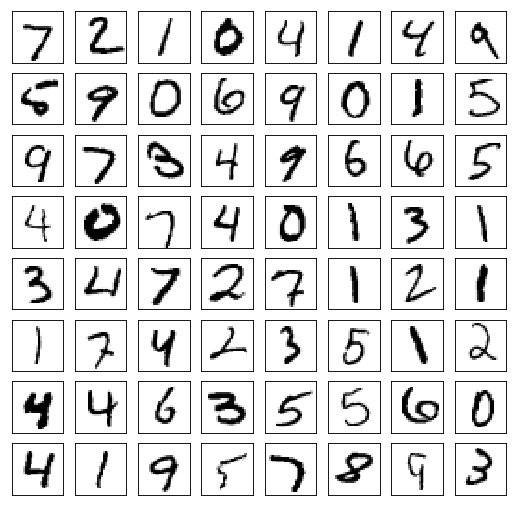

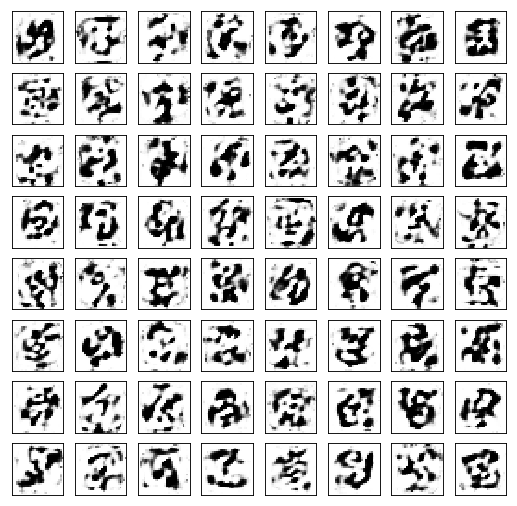

In [19]:
plot_mnist(data.data.numpy(), (8, 8))
plot_mnist(to_plot, (8, 8))
plot_mnist(f_to_plot, (8, 8))
plot_mnist(dec_to_plot, (8, 8))

### Генерация новых изображений


In [20]:
from torch.autograd import Variable

def generate_image(img):
    
    gen_img_par = Variable(img, requires_grad=True)
    output_vector = []
    loss_stats = []
    
    gen_optim = optim.Adam([gen_img_par], lr=1e-3, weight_decay=0.)

    for i in range(1, 1000001):  
                
        target = model.E(gen_img_par.view(-1, 28*28))
                
        gen_optim.zero_grad()
        loss = F.mse_loss(target, latent_vector)    
        loss.backward()                   
        gen_optim.step()
        
        if i % 2000 == 0:    
            print ("Iteration {}: loss={}".format(i,loss))
            ls = loss.detach().numpy()            
            loss_stats.append(ls)
                        
            if len(loss_stats) > 5:    
                if ls > loss_stats[-2] and ls > loss_stats[-3]:
                    print ("Loss is rising .. stop")
                    break

        if i % 40000 == 0:
            to_plot = gen_img_par.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
            plot_mnist(to_plot, (8, 8))
                        
    return gen_img_par    

### Генерация изображений из батча

In [21]:
img, _ = next(iter(test_loader))
to_plot = img.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (8, 8))

Iteration 2000: loss=0.0021439045667648315
Iteration 4000: loss=0.00040954549331218004
Iteration 6000: loss=8.888657612260431e-05
Iteration 8000: loss=3.485369961708784e-05
Iteration 10000: loss=2.214839514635969e-05
Iteration 12000: loss=1.6698253602953628e-05
Iteration 14000: loss=1.3727875739277806e-05
Iteration 16000: loss=1.1996871762676165e-05
Iteration 18000: loss=1.0892559657804668e-05
Iteration 20000: loss=1.0141441634914372e-05
Iteration 22000: loss=9.589255569153465e-06
Iteration 24000: loss=9.161124580714386e-06
Iteration 26000: loss=8.819667527859565e-06
Iteration 28000: loss=8.539482223568484e-06
Iteration 30000: loss=8.303842150780838e-06
Iteration 32000: loss=8.101839739538264e-06
Iteration 34000: loss=7.924196324893273e-06
Iteration 36000: loss=7.765399459458422e-06
Iteration 38000: loss=7.624156296515139e-06
Iteration 40000: loss=7.4985950959671754e-06


Iteration 42000: loss=7.386414836219046e-06
Iteration 44000: loss=7.285461379069602e-06
Iteration 46000: loss=7.1939102781470865e-06
Iteration 48000: loss=7.110321803338593e-06
Iteration 50000: loss=7.033539986878168e-06
Iteration 52000: loss=6.962728548387531e-06
Iteration 54000: loss=6.897225830471143e-06
Iteration 56000: loss=6.836567081336398e-06
Iteration 58000: loss=6.780343937862199e-06
Iteration 60000: loss=6.728185780957574e-06
Iteration 62000: loss=6.679765647277236e-06
Iteration 64000: loss=6.634709279751405e-06
Iteration 66000: loss=6.59269790048711e-06
Iteration 68000: loss=6.5534477471373975e-06
Iteration 70000: loss=6.51661639494705e-06
Iteration 72000: loss=6.4819851104402915e-06
Iteration 74000: loss=6.449315606005257e-06
Iteration 76000: loss=6.41840415482875e-06
Iteration 78000: loss=6.389102054527029e-06
Iteration 80000: loss=6.36124195807497e-06


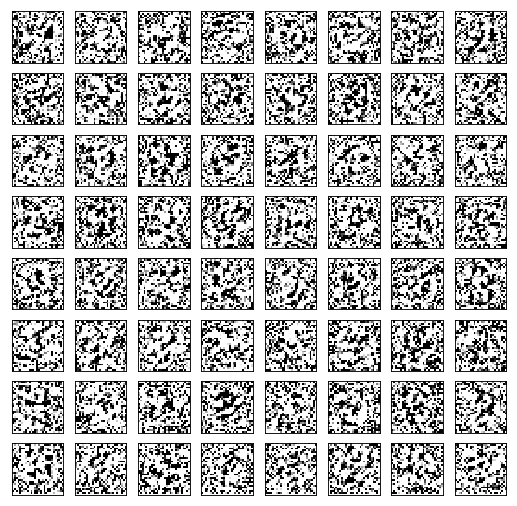

Iteration 82000: loss=6.33469471722492e-06
Iteration 84000: loss=6.309329819487175e-06
Iteration 86000: loss=6.285084509727312e-06
Iteration 88000: loss=6.261871931201313e-06
Iteration 90000: loss=6.23960659140721e-06
Iteration 92000: loss=6.218248472578125e-06
Iteration 94000: loss=6.19775209997897e-06
Iteration 96000: loss=6.178040621307446e-06
Iteration 98000: loss=6.159085842227796e-06
Iteration 100000: loss=6.1408359215420205e-06
Iteration 102000: loss=6.123271305114031e-06
Iteration 104000: loss=6.1063301473041065e-06
Iteration 106000: loss=6.089988801250001e-06
Iteration 108000: loss=6.074209522921592e-06
Iteration 110000: loss=6.058957751520211e-06
Iteration 112000: loss=6.044204837962752e-06
Iteration 114000: loss=6.0299007600406185e-06
Iteration 116000: loss=6.016024144628318e-06
Iteration 118000: loss=6.0025445236533415e-06
Iteration 120000: loss=5.989429610053776e-06


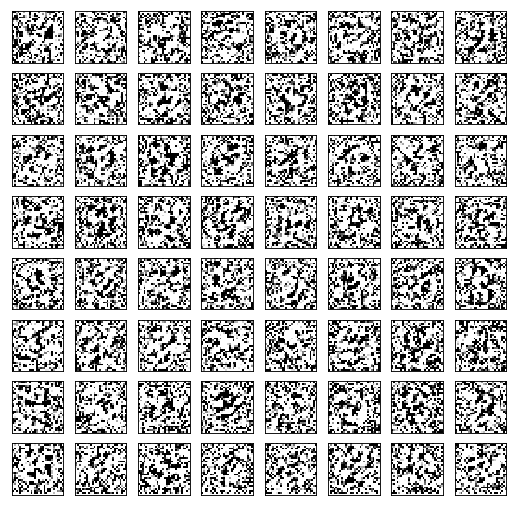

Iteration 122000: loss=5.976666670903796e-06
Iteration 124000: loss=5.964248430245789e-06
Iteration 126000: loss=5.9521694311115425e-06
Iteration 128000: loss=5.9404137573437765e-06
Iteration 130000: loss=5.9289909586368594e-06
Iteration 132000: loss=5.9178878473176155e-06
Iteration 134000: loss=5.907095328439027e-06
Iteration 136000: loss=5.896612037759041e-06
Iteration 138000: loss=5.886407507205149e-06
Iteration 140000: loss=5.876485374756157e-06
Iteration 142000: loss=5.866834726475645e-06
Iteration 144000: loss=5.857446012669243e-06
Iteration 146000: loss=5.848300588695565e-06
Iteration 148000: loss=5.839391178596998e-06
Iteration 150000: loss=5.830705958942417e-06
Iteration 152000: loss=5.822231742058648e-06
Iteration 154000: loss=5.8139617067354266e-06
Iteration 156000: loss=5.805870387121104e-06
Iteration 158000: loss=5.7979609664471354e-06
Iteration 160000: loss=5.79022207602975e-06


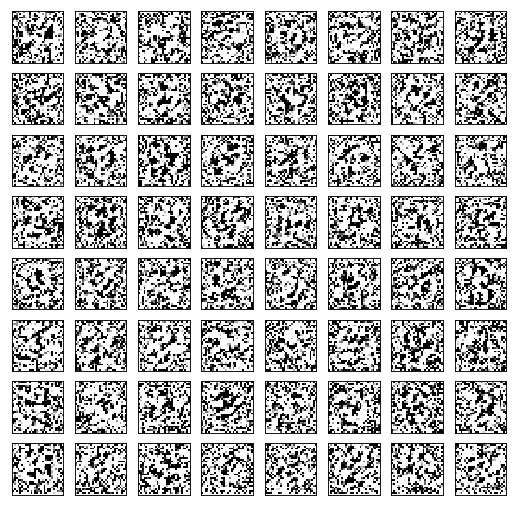

Iteration 162000: loss=5.782648713648086e-06
Iteration 164000: loss=5.775225417892216e-06
Iteration 166000: loss=5.767957190982997e-06
Iteration 168000: loss=5.760834483226063e-06
Iteration 170000: loss=5.7538622968422715e-06
Iteration 172000: loss=5.747031536884606e-06
Iteration 174000: loss=5.740333108406048e-06
Iteration 176000: loss=5.733769285143353e-06
Iteration 178000: loss=5.727340976591222e-06
Iteration 180000: loss=5.72103544982383e-06
Iteration 182000: loss=5.714857252314687e-06
Iteration 184000: loss=5.708805019821739e-06
Iteration 186000: loss=5.702869657397969e-06
Iteration 188000: loss=5.6970588957483415e-06
Iteration 190000: loss=5.6913672779046465e-06
Iteration 192000: loss=5.685794349119533e-06
Iteration 194000: loss=5.680330559698632e-06
Iteration 196000: loss=5.674975454894593e-06
Iteration 198000: loss=5.669735855917679e-06
Iteration 200000: loss=5.664609489031136e-06


Iteration 202000: loss=5.659584530803841e-06
Iteration 204000: loss=5.654652795783477e-06
Iteration 206000: loss=5.6498201956856064e-06
Iteration 208000: loss=5.645088094752282e-06
Iteration 210000: loss=5.640444214805029e-06
Iteration 212000: loss=5.635891284327954e-06
Iteration 214000: loss=5.63141611564788e-06
Iteration 216000: loss=5.627025075227721e-06
Iteration 218000: loss=5.622709068120457e-06
Iteration 220000: loss=5.6184744607890025e-06
Iteration 222000: loss=5.614307156065479e-06
Iteration 224000: loss=5.610203061223729e-06
Iteration 226000: loss=5.6061662689899094e-06
Iteration 228000: loss=5.602195415121969e-06
Iteration 230000: loss=5.598284587904345e-06
Iteration 232000: loss=5.594441518042004e-06
Iteration 234000: loss=5.590657110587927e-06
Iteration 236000: loss=5.5869322750368156e-06
Iteration 238000: loss=5.5832679208833724e-06
Iteration 240000: loss=5.579664957622299e-06


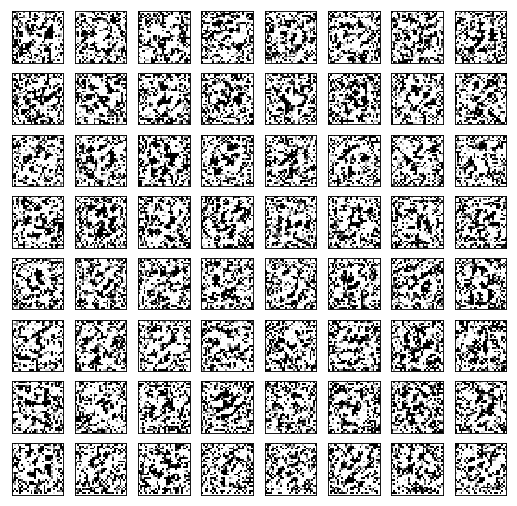

Iteration 242000: loss=5.5761261137377005e-06
Iteration 244000: loss=5.5726495702401735e-06
Iteration 246000: loss=5.5692366913717706e-06
Iteration 248000: loss=5.56587110622786e-06
Iteration 250000: loss=5.562573278439231e-06
Iteration 252000: loss=5.559338205785025e-06
Iteration 254000: loss=5.556153155339416e-06
Iteration 256000: loss=5.553033588512335e-06
Iteration 258000: loss=5.549970410356764e-06
Iteration 260000: loss=5.546949068957474e-06
Iteration 262000: loss=5.543998668144923e-06
Iteration 264000: loss=5.541093287320109e-06
Iteration 266000: loss=5.538237019209191e-06
Iteration 268000: loss=5.535437594517134e-06
Iteration 270000: loss=5.532681825570762e-06
Iteration 272000: loss=5.529973350348882e-06
Iteration 274000: loss=5.5273130783461966e-06
Iteration 276000: loss=5.524694643099792e-06
Iteration 278000: loss=5.522118954104371e-06
Iteration 280000: loss=5.5195832828758284e-06


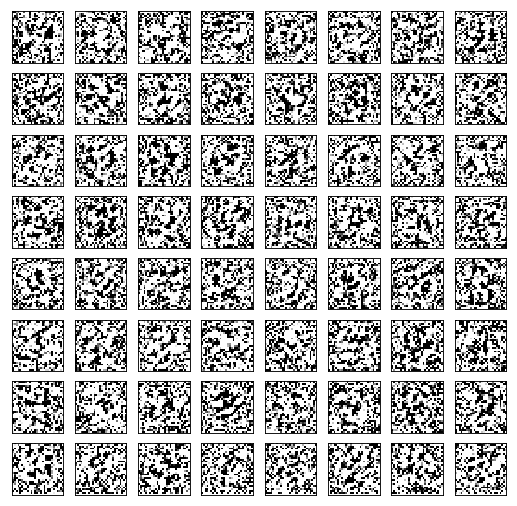

Iteration 282000: loss=5.517086719919462e-06
Iteration 284000: loss=5.514636995940236e-06
Iteration 286000: loss=5.512224561243784e-06
Iteration 288000: loss=5.5098462325986475e-06
Iteration 290000: loss=5.5075029194995295e-06
Iteration 292000: loss=5.505190983967623e-06
Iteration 294000: loss=5.502908152266173e-06
Iteration 296000: loss=5.5006580623739865e-06
Iteration 298000: loss=5.4984429880278185e-06
Iteration 300000: loss=5.496254289028002e-06
Iteration 302000: loss=5.494094693858642e-06
Iteration 304000: loss=5.491965566761792e-06
Iteration 306000: loss=5.489860086527187e-06
Iteration 308000: loss=5.487783255375689e-06
Iteration 310000: loss=5.485728252097033e-06
Iteration 312000: loss=5.483698714670027e-06
Iteration 314000: loss=5.4816810006741434e-06
Iteration 316000: loss=5.4796942094981205e-06
Iteration 318000: loss=5.477716968016466e-06
Iteration 320000: loss=5.475762009155005e-06


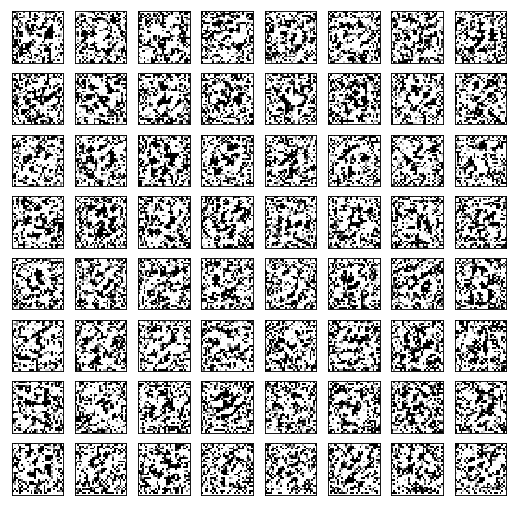

Iteration 322000: loss=5.473825694934931e-06
Iteration 324000: loss=5.471893473441014e-06
Iteration 326000: loss=5.46997807759908e-06
Iteration 328000: loss=5.4680667744833045e-06
Iteration 330000: loss=5.466173661261564e-06
Iteration 332000: loss=5.464276455313666e-06
Iteration 334000: loss=5.462385161081329e-06
Iteration 336000: loss=5.460501142806606e-06
Iteration 338000: loss=5.458628493215656e-06
Iteration 340000: loss=5.456750841403846e-06
Iteration 342000: loss=5.4548931984754745e-06
Iteration 344000: loss=5.453043740999419e-06
Iteration 346000: loss=5.451209290185943e-06
Iteration 348000: loss=5.4493857533088885e-06
Iteration 350000: loss=5.447573130368255e-06
Iteration 352000: loss=5.445778697321657e-06
Iteration 354000: loss=5.44400018043234e-06
Iteration 356000: loss=5.442234396468848e-06
Iteration 358000: loss=5.440477252705023e-06
Iteration 360000: loss=5.438733751361724e-06


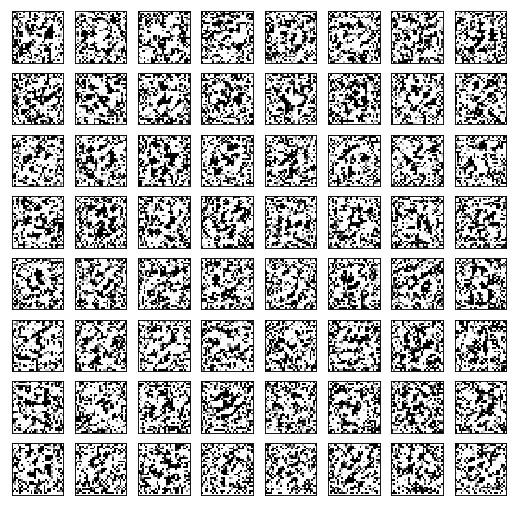

Iteration 362000: loss=5.437011168396566e-06
Iteration 364000: loss=5.4352990446204785e-06
Iteration 366000: loss=5.433594196802005e-06
Iteration 368000: loss=5.431897079688497e-06
Iteration 370000: loss=5.430227702163393e-06
Iteration 372000: loss=5.428561053122394e-06
Iteration 374000: loss=5.426911229733378e-06
Iteration 376000: loss=5.4252736845228355e-06
Iteration 378000: loss=5.42363932254375e-06
Iteration 380000: loss=5.422027243184857e-06
Iteration 382000: loss=5.420428806246491e-06
Iteration 384000: loss=5.418834916781634e-06
Iteration 386000: loss=5.417260581452865e-06
Iteration 388000: loss=5.41570352652343e-06
Iteration 390000: loss=5.414148290583398e-06
Iteration 392000: loss=5.412608516053297e-06
Iteration 394000: loss=5.4110832934384234e-06
Iteration 396000: loss=5.409566711023217e-06
Iteration 398000: loss=5.40806513527059e-06
Iteration 400000: loss=5.406572654464981e-06


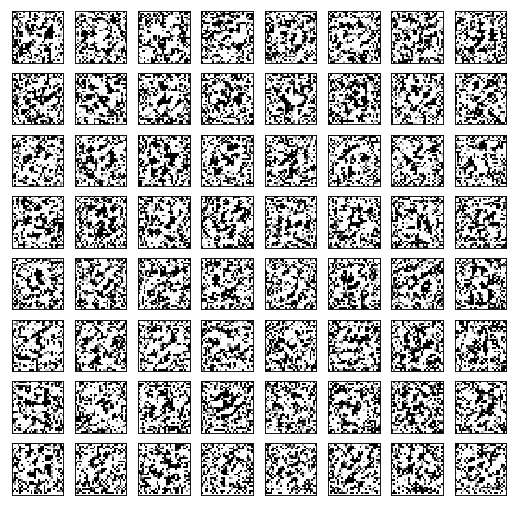

Iteration 402000: loss=5.405094270827249e-06
Iteration 404000: loss=5.403629529610043e-06
Iteration 406000: loss=5.402172519097803e-06
Iteration 408000: loss=5.400733698479598e-06
Iteration 410000: loss=5.399297606345499e-06
Iteration 412000: loss=5.3978815230948385e-06
Iteration 414000: loss=5.3964677135809325e-06
Iteration 416000: loss=5.3950698202243075e-06
Iteration 418000: loss=5.393674655351788e-06
Iteration 420000: loss=5.392297680373304e-06
Iteration 422000: loss=5.390933438320644e-06
Iteration 424000: loss=5.389566013036529e-06
Iteration 426000: loss=5.3882126849202905e-06
Iteration 428000: loss=5.38686845175107e-06
Iteration 430000: loss=5.385536496760324e-06
Iteration 432000: loss=5.3842072702536825e-06
Iteration 434000: loss=5.382886229199357e-06
Iteration 436000: loss=5.38157928531291e-06
Iteration 438000: loss=5.380279162636725e-06
Iteration 440000: loss=5.3789926823810674e-06


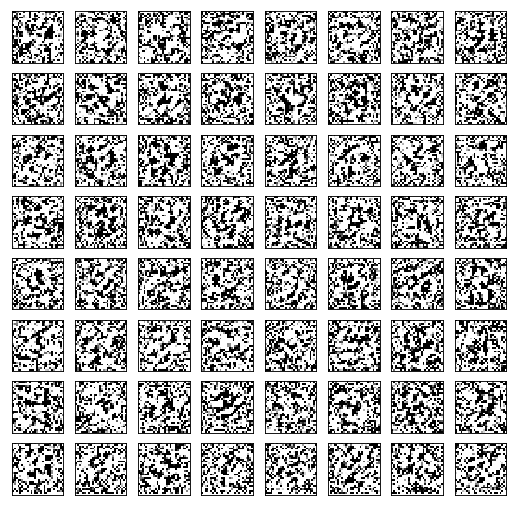

Iteration 442000: loss=5.377707111620111e-06
Iteration 444000: loss=5.376440185500542e-06
Iteration 446000: loss=5.375172804633621e-06
Iteration 448000: loss=5.373913154471666e-06
Iteration 450000: loss=5.3726680562249385e-06
Iteration 452000: loss=5.371429324441124e-06
Iteration 454000: loss=5.370195140130818e-06
Iteration 456000: loss=5.368976871977793e-06
Iteration 458000: loss=5.367760422814172e-06
Iteration 460000: loss=5.3665517043555155e-06
Iteration 462000: loss=5.365357083064737e-06
Iteration 464000: loss=5.364159278542502e-06
Iteration 466000: loss=5.3629751164407935e-06
Iteration 468000: loss=5.361795047065243e-06
Iteration 470000: loss=5.360623163142009e-06
Iteration 472000: loss=5.359452643460827e-06
Iteration 474000: loss=5.358298949431628e-06
Iteration 476000: loss=5.3571516218653414e-06
Iteration 478000: loss=5.356002475309651e-06
Iteration 480000: loss=5.35486287844833e-06


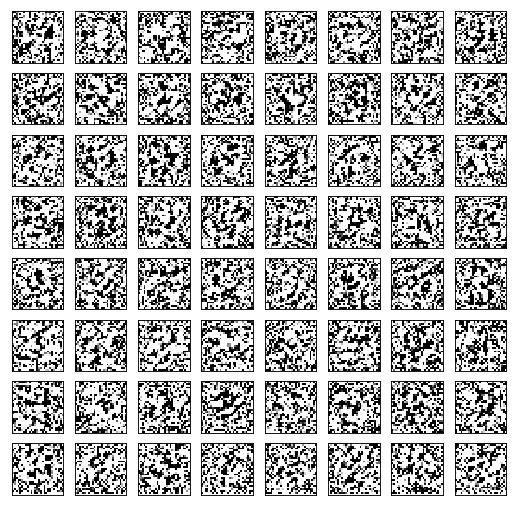

Iteration 482000: loss=5.353732831281377e-06
Iteration 484000: loss=5.352607331587933e-06
Iteration 486000: loss=5.351495019567665e-06
Iteration 488000: loss=5.35037952431594e-06
Iteration 490000: loss=5.349270850274479e-06
Iteration 492000: loss=5.348172635422088e-06
Iteration 494000: loss=5.347078968043206e-06
Iteration 496000: loss=5.345985755411675e-06
Iteration 498000: loss=5.344903456716565e-06
Iteration 500000: loss=5.343828888726421e-06
Iteration 502000: loss=5.342753411241574e-06
Iteration 504000: loss=5.341686119209044e-06
Iteration 506000: loss=5.3406256483867764e-06
Iteration 508000: loss=5.339565177564509e-06
Iteration 510000: loss=5.338509708963102e-06
Iteration 512000: loss=5.337452421372291e-06
Iteration 514000: loss=5.336399226507638e-06
Iteration 516000: loss=5.335339210432721e-06
Iteration 518000: loss=5.334284196578665e-06
Iteration 520000: loss=5.333215995051432e-06


Iteration 522000: loss=5.3321341511036735e-06
Iteration 524000: loss=5.331031388777774e-06
Iteration 526000: loss=5.329913165041944e-06
Iteration 528000: loss=5.328770839696517e-06
Iteration 530000: loss=5.3276080507203005e-06
Iteration 532000: loss=5.326424798113294e-06
Iteration 534000: loss=5.325243819243042e-06
Iteration 536000: loss=5.3240514716890175e-06
Iteration 538000: loss=5.322865035850555e-06
Iteration 540000: loss=5.321683602232952e-06
Iteration 542000: loss=5.320523996488191e-06
Iteration 544000: loss=5.319380761648063e-06
Iteration 546000: loss=5.318253442965215e-06
Iteration 548000: loss=5.317138857208192e-06
Iteration 550000: loss=5.316040187608451e-06
Iteration 552000: loss=5.314963800628902e-06
Iteration 554000: loss=5.31390560354339e-06
Iteration 556000: loss=5.312863777362509e-06
Iteration 558000: loss=5.311834684107453e-06
Iteration 560000: loss=5.310819233272923e-06


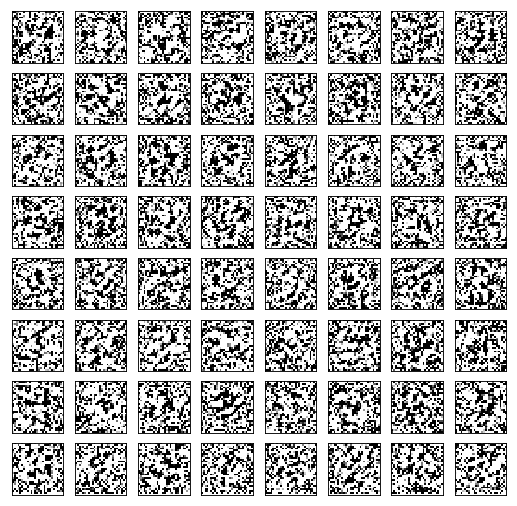

Iteration 562000: loss=5.309816970111569e-06
Iteration 564000: loss=5.3088351705810055e-06
Iteration 566000: loss=5.307869287207723e-06
Iteration 568000: loss=5.30691386302351e-06
Iteration 570000: loss=5.30598026671214e-06
Iteration 572000: loss=5.305055765347788e-06
Iteration 574000: loss=5.3041412684251554e-06
Iteration 576000: loss=5.30325087311212e-06
Iteration 578000: loss=5.302371846482856e-06
Iteration 580000: loss=5.301505098032067e-06
Iteration 582000: loss=5.300650627759751e-06
Iteration 584000: loss=5.29981389263412e-06
Iteration 586000: loss=5.29898807144491e-06
Iteration 588000: loss=5.298171799950069e-06
Iteration 590000: loss=5.297373718349263e-06
Iteration 592000: loss=5.29657700099051e-06
Iteration 594000: loss=5.295791652315529e-06
Iteration 596000: loss=5.295019946061075e-06
Iteration 598000: loss=5.2942559705115855e-06
Iteration 600000: loss=5.293496087688254e-06


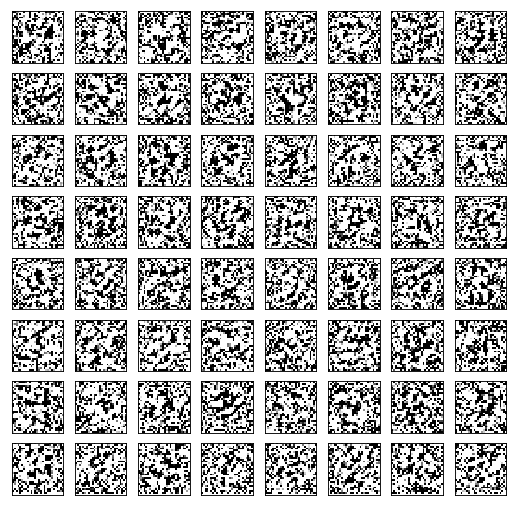

Iteration 602000: loss=5.292741207085783e-06
Iteration 604000: loss=5.2919967856723815e-06
Iteration 606000: loss=5.2912596402165946e-06
Iteration 608000: loss=5.290533408697229e-06
Iteration 610000: loss=5.28980535818846e-06
Iteration 612000: loss=5.289085947879357e-06
Iteration 614000: loss=5.288378815748729e-06
Iteration 616000: loss=5.287668500386644e-06
Iteration 618000: loss=5.286970917950384e-06
Iteration 620000: loss=5.28627106177737e-06
Iteration 622000: loss=5.285577117319917e-06
Iteration 624000: loss=5.284892722556833e-06
Iteration 626000: loss=5.284204689814942e-06
Iteration 628000: loss=5.283524842525367e-06
Iteration 630000: loss=5.282855454424862e-06
Iteration 632000: loss=5.28218242834555e-06
Iteration 634000: loss=5.281519406707957e-06
Iteration 636000: loss=5.280855475575663e-06
Iteration 638000: loss=5.280202003632439e-06
Iteration 640000: loss=5.279547622194514e-06


Iteration 642000: loss=5.2788996072195005e-06
Iteration 644000: loss=5.2782506827497855e-06
Iteration 646000: loss=5.277614945953246e-06
Iteration 648000: loss=5.276973297441145e-06
Iteration 650000: loss=5.276349384075729e-06
Iteration 652000: loss=5.275717740005348e-06
Iteration 654000: loss=5.2750906434084754e-06
Iteration 656000: loss=5.274469913274515e-06
Iteration 658000: loss=5.273859642329626e-06
Iteration 660000: loss=5.273243004921824e-06
Iteration 662000: loss=5.2726350077136885e-06
Iteration 664000: loss=5.272033831715817e-06
Iteration 666000: loss=5.2714258345076814e-06
Iteration 668000: loss=5.270826022751862e-06
Iteration 670000: loss=5.270232577458955e-06
Iteration 672000: loss=5.269641405902803e-06
Iteration 674000: loss=5.269048415357247e-06
Iteration 676000: loss=5.2684695219795685e-06
Iteration 678000: loss=5.267885171633679e-06
Iteration 680000: loss=5.267311280476861e-06


Iteration 682000: loss=5.266732841846533e-06
Iteration 684000: loss=5.266156222205609e-06
Iteration 686000: loss=5.265590971248457e-06
Iteration 688000: loss=5.265027539280709e-06
Iteration 690000: loss=5.2644641073129606e-06
Iteration 692000: loss=5.263910679786932e-06
Iteration 694000: loss=5.263353159534745e-06
Iteration 696000: loss=5.26279654877726e-06
Iteration 698000: loss=5.262245849735336e-06
Iteration 700000: loss=5.26170379089308e-06
Iteration 702000: loss=5.261162641545525e-06
Iteration 704000: loss=5.260620582703268e-06
Iteration 706000: loss=5.260081707092468e-06
Iteration 708000: loss=5.259547378955176e-06
Iteration 710000: loss=5.259019872028148e-06
Iteration 712000: loss=5.258486453385558e-06
Iteration 714000: loss=5.25796440342674e-06
Iteration 716000: loss=5.257443717709975e-06
Iteration 718000: loss=5.256919848761754e-06
Iteration 720000: loss=5.256407348497305e-06


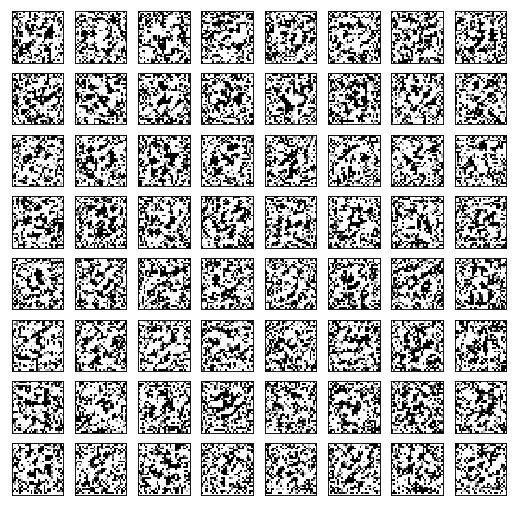

Iteration 722000: loss=5.255892574496102e-06
Iteration 724000: loss=5.2553800742316525e-06
Iteration 726000: loss=5.254869847703958e-06
Iteration 728000: loss=5.2543587116815615e-06
Iteration 730000: loss=5.2538543968694285e-06
Iteration 732000: loss=5.253346898825839e-06
Iteration 734000: loss=5.252846676739864e-06
Iteration 736000: loss=5.252347364148591e-06
Iteration 738000: loss=5.2518516895361245e-06
Iteration 740000: loss=5.25135692441836e-06
Iteration 742000: loss=5.250861249805894e-06
Iteration 744000: loss=5.250371486908989e-06
Iteration 746000: loss=5.249882633506786e-06
Iteration 748000: loss=5.249392870609881e-06
Iteration 750000: loss=5.248904017207678e-06
Iteration 752000: loss=5.248416528047528e-06
Iteration 754000: loss=5.247933586360887e-06
Iteration 756000: loss=5.247448825684842e-06
Iteration 758000: loss=5.246970431471709e-06
Iteration 760000: loss=5.246492037258577e-06


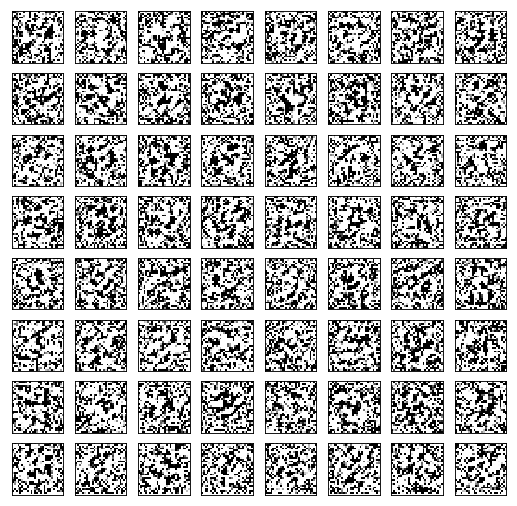

Iteration 762000: loss=5.246013643045444e-06
Iteration 764000: loss=5.245540705800522e-06
Iteration 766000: loss=5.2450704970397055e-06
Iteration 768000: loss=5.244600288278889e-06
Iteration 770000: loss=5.244128260528669e-06
Iteration 772000: loss=5.2436685109569225e-06
Iteration 774000: loss=5.243201485427562e-06
Iteration 776000: loss=5.242740371613763e-06
Iteration 778000: loss=5.242283350526122e-06
Iteration 780000: loss=5.241831331659341e-06
Iteration 782000: loss=5.241376129561104e-06
Iteration 784000: loss=5.240932296146639e-06
Iteration 786000: loss=5.240481186774559e-06
Iteration 788000: loss=5.240046903054463e-06
Iteration 790000: loss=5.2396035243873484e-06
Iteration 792000: loss=5.239167421677848e-06
Iteration 794000: loss=5.238737685431261e-06
Iteration 796000: loss=5.238308858679375e-06
Iteration 798000: loss=5.237879122432787e-06
Iteration 800000: loss=5.237458935880568e-06


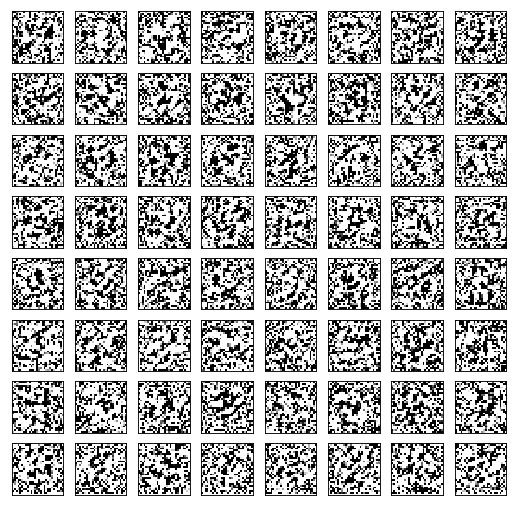

Iteration 802000: loss=5.2370401135704014e-06
Iteration 804000: loss=5.236616289039375e-06
Iteration 806000: loss=5.236205197434174e-06
Iteration 808000: loss=5.235790922597516e-06
Iteration 810000: loss=5.235383923718473e-06
Iteration 812000: loss=5.234974651102675e-06
Iteration 814000: loss=5.2345726544444915e-06
Iteration 816000: loss=5.2341720220283605e-06
Iteration 818000: loss=5.233773208601633e-06
Iteration 820000: loss=5.233377578406362e-06
Iteration 822000: loss=5.232987405179301e-06
Iteration 824000: loss=5.232594503468135e-06
Iteration 826000: loss=5.2322016017569695e-06
Iteration 828000: loss=5.23181734024547e-06
Iteration 830000: loss=5.231438535702182e-06
Iteration 832000: loss=5.231049726717174e-06
Iteration 834000: loss=5.230673650657991e-06
Iteration 836000: loss=5.230295300862053e-06
Iteration 838000: loss=5.229915132076712e-06
Iteration 840000: loss=5.229545422480442e-06


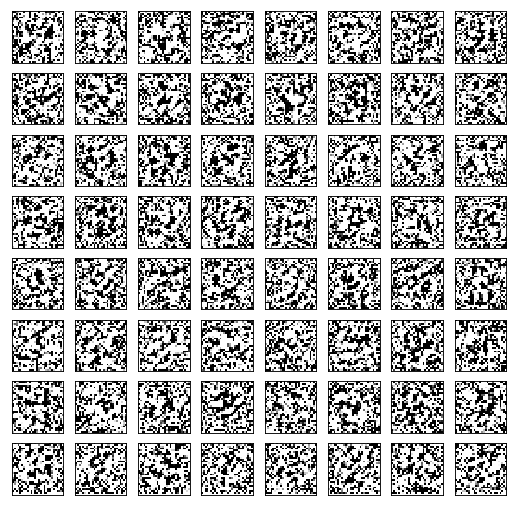

Iteration 842000: loss=5.229172074905364e-06
Iteration 844000: loss=5.228804639045848e-06
Iteration 846000: loss=5.2284326557128225e-06
Iteration 848000: loss=5.228071131568868e-06
Iteration 850000: loss=5.2277073336881585e-06
Iteration 852000: loss=5.227349447523011e-06
Iteration 854000: loss=5.226992016105214e-06
Iteration 856000: loss=5.226632765698014e-06
Iteration 858000: loss=5.226278517511673e-06
Iteration 860000: loss=5.225926088314736e-06
Iteration 862000: loss=5.225570475886343e-06
Iteration 864000: loss=5.225227141636424e-06
Iteration 866000: loss=5.224874257692136e-06
Iteration 868000: loss=5.224529559200164e-06
Iteration 870000: loss=5.224186224950245e-06
Iteration 872000: loss=5.223837433732115e-06
Iteration 874000: loss=5.223496827966301e-06
Iteration 876000: loss=5.223155312705785e-06
Iteration 878000: loss=5.2228169806767255e-06
Iteration 880000: loss=5.222473191679455e-06


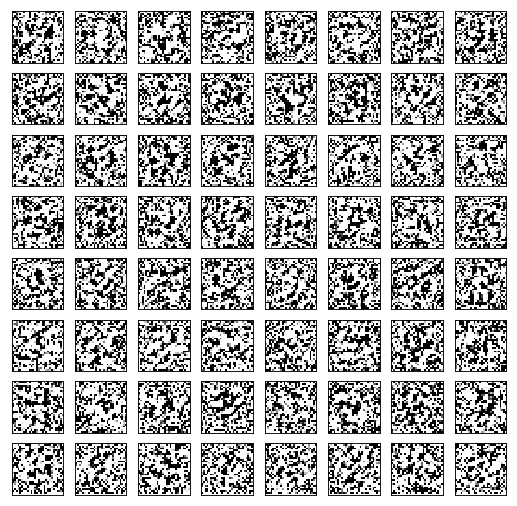

Iteration 882000: loss=5.222133040660992e-06
Iteration 884000: loss=5.2218038035789505e-06
Iteration 886000: loss=5.221464107307838e-06
Iteration 888000: loss=5.221133960731095e-06
Iteration 890000: loss=5.220800176175544e-06
Iteration 892000: loss=5.220466391619993e-06
Iteration 894000: loss=5.2201335165591445e-06
Iteration 896000: loss=5.219805643719155e-06
Iteration 898000: loss=5.219480044615921e-06
Iteration 900000: loss=5.219148533797124e-06
Iteration 902000: loss=5.218822479946539e-06
Iteration 904000: loss=5.2184909691277426e-06
Iteration 906000: loss=5.21817173648742e-06
Iteration 908000: loss=5.2178502301103435e-06
Iteration 910000: loss=5.217525540501811e-06
Iteration 912000: loss=5.217204943619436e-06
Iteration 914000: loss=5.2168852562317625e-06
Iteration 916000: loss=5.216563295107335e-06
Iteration 918000: loss=5.216245426709065e-06
Iteration 920000: loss=5.215928467805497e-06


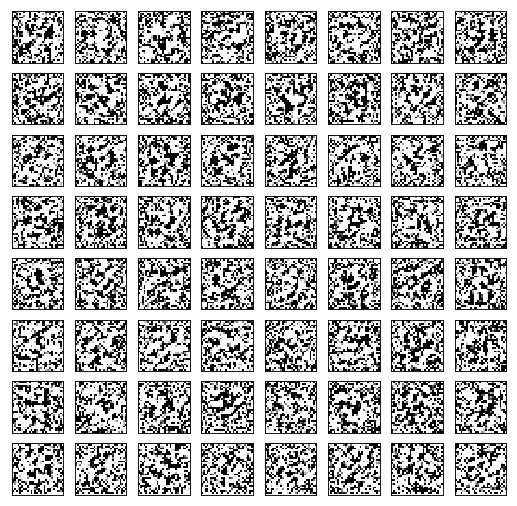

Iteration 922000: loss=5.215609235165175e-06
Iteration 924000: loss=5.215294549998362e-06
Iteration 926000: loss=5.214983957557706e-06
Iteration 928000: loss=5.214673365117051e-06
Iteration 930000: loss=5.21436004419229e-06
Iteration 932000: loss=5.21404717801488e-06
Iteration 934000: loss=5.213742952037137e-06
Iteration 936000: loss=5.213430085859727e-06
Iteration 938000: loss=5.21312358614523e-06
Iteration 940000: loss=5.2128234528936446e-06
Iteration 942000: loss=5.212516953179147e-06
Iteration 944000: loss=5.212216365180211e-06
Iteration 946000: loss=5.21191304869717e-06
Iteration 948000: loss=5.2116220103926025e-06
Iteration 950000: loss=5.211319603404263e-06
Iteration 952000: loss=5.211023108131485e-06
Iteration 954000: loss=5.210721610637847e-06
Iteration 956000: loss=5.210431481827982e-06
Iteration 958000: loss=5.21013816978666e-06
Iteration 960000: loss=5.2098516789556015e-06


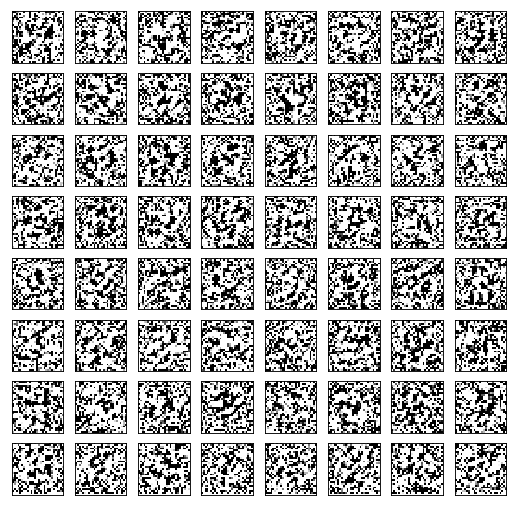

Iteration 962000: loss=5.209562004893087e-06
Iteration 964000: loss=5.209275968809379e-06
Iteration 966000: loss=5.208984930504812e-06
Iteration 968000: loss=5.208708898862824e-06
Iteration 970000: loss=5.2084301387367304e-06
Iteration 972000: loss=5.208140464674216e-06
Iteration 974000: loss=5.207862614042824e-06
Iteration 976000: loss=5.207583853916731e-06
Iteration 978000: loss=5.207300091569778e-06
Iteration 980000: loss=5.207026788411895e-06
Iteration 982000: loss=5.206755304243416e-06
Iteration 984000: loss=5.206484729569638e-06
Iteration 986000: loss=5.2062150643905625e-06
Iteration 988000: loss=5.205939942243276e-06
Iteration 990000: loss=5.205673915043008e-06
Iteration 992000: loss=5.205403795116581e-06
Iteration 994000: loss=5.205140041653067e-06
Iteration 996000: loss=5.204872650210746e-06
Iteration 998000: loss=5.20461344422074e-06
Iteration 1000000: loss=5.204357876209542e-06


In [22]:
new_image_batch = generate_image(img)

In [23]:
to_plot = new_image_batch.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (8, 8))

Преобразуем сгенерированные изображения с помощью энкодера - на выходе получается матрица, близкая к единичной.

In [24]:
latent = model.E(new_image_batch.view(-1, 28*28))
print (latent.shape)
print (latent)

torch.Size([64, 64])
tensor([[ 9.8421e-01, -7.4260e-05,  8.9750e-05,  ...,  4.3556e-05,
          7.3034e-06,  1.5992e-04],
        [-5.6103e-05,  9.8254e-01, -1.8373e-05,  ..., -7.0289e-05,
          3.1054e-05,  5.0515e-05],
        [ 1.1940e-04, -1.1317e-05,  9.8596e-01,  ..., -4.2006e-05,
          3.5197e-05,  8.7768e-06],
        ...,
        [ 2.0385e-05, -6.5804e-05, -6.4000e-05,  ...,  9.8701e-01,
          3.7547e-05,  5.3316e-05],
        [ 4.0248e-05, -2.3514e-05,  9.8646e-06,  ..., -5.1036e-05,
          9.8267e-01, -7.4580e-05],
        [ 7.2837e-05,  4.0367e-05, -1.2597e-04,  ...,  4.2036e-05,
         -5.4330e-05,  9.8340e-01]])


Сравним сгенерированные изображения с выходом декодера

tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1])


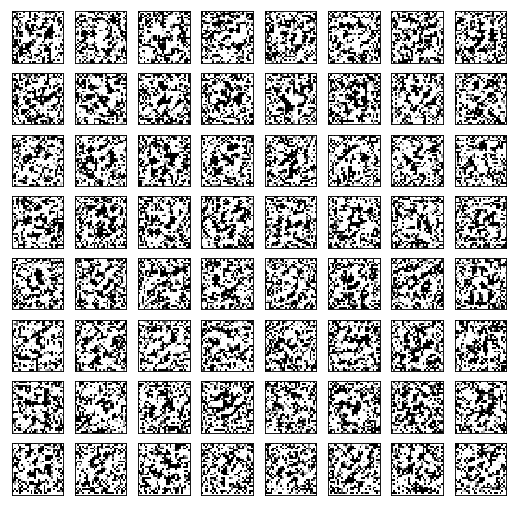

In [25]:
to_plot = new_image_batch.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()

with torch.no_grad():
    encoded = model.E(new_image_batch.view(-1, 28*28))
    print((encoded > 0.2).sum(1))
    encoded[encoded < 0.2] = 0.
    decoded_f = model.decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

plot_mnist(to_plot, (8, 8))
plot_mnist(f_to_plot, (8, 8))    

### Генерация изображений из случайного шума

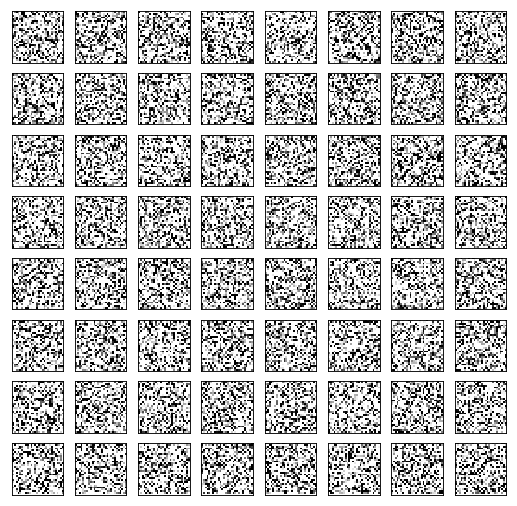

In [26]:
img = torch.randn(64, 784) 
to_plot = img.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (8, 8))

Iteration 2000: loss=0.0004913241718895733
Iteration 4000: loss=0.00013879781181458384
Iteration 6000: loss=6.399908306775615e-05
Iteration 8000: loss=3.5945282434113324e-05
Iteration 10000: loss=2.3164262529462576e-05
Iteration 12000: loss=1.6862091797520407e-05
Iteration 14000: loss=1.3556220437749289e-05
Iteration 16000: loss=1.1682546755764633e-05
Iteration 18000: loss=1.0523285709496122e-05
Iteration 20000: loss=9.743749615154229e-06
Iteration 22000: loss=9.183678230328951e-06
Iteration 24000: loss=8.761252502154093e-06
Iteration 26000: loss=8.430190064245835e-06
Iteration 28000: loss=8.162414815160446e-06
Iteration 30000: loss=7.940147042972967e-06
Iteration 32000: loss=7.752031706331763e-06
Iteration 34000: loss=7.590409950353205e-06
Iteration 36000: loss=7.449880286003463e-06
Iteration 38000: loss=7.326415470743086e-06
Iteration 40000: loss=7.216896392492345e-06


Iteration 42000: loss=7.118965186236892e-06
Iteration 44000: loss=7.030751930869883e-06
Iteration 46000: loss=6.950726401555585e-06
Iteration 48000: loss=6.877709438413149e-06
Iteration 50000: loss=6.810732884332538e-06
Iteration 52000: loss=6.748988653271226e-06
Iteration 54000: loss=6.691821454296587e-06
Iteration 56000: loss=6.63867194816703e-06
Iteration 58000: loss=6.589120857825037e-06
Iteration 60000: loss=6.542806204379303e-06
Iteration 62000: loss=6.499419214378577e-06
Iteration 64000: loss=6.458722509705694e-06
Iteration 66000: loss=6.420483714464353e-06
Iteration 68000: loss=6.384489097399637e-06
Iteration 70000: loss=6.350547664624173e-06
Iteration 72000: loss=6.3184797909343615e-06
Iteration 74000: loss=6.2881558733351994e-06
Iteration 76000: loss=6.259420842980035e-06
Iteration 78000: loss=6.232139639905654e-06
Iteration 80000: loss=6.206201760505792e-06


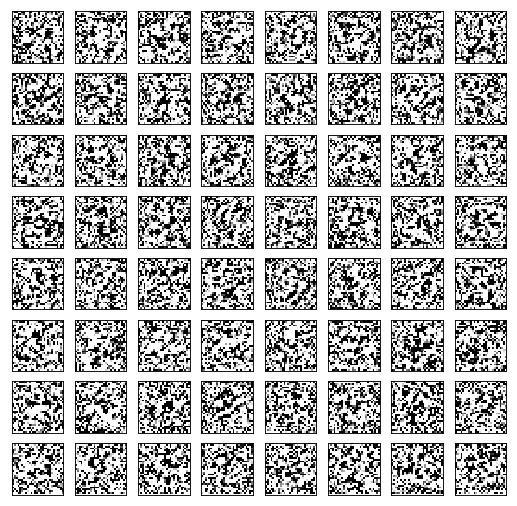

Iteration 82000: loss=6.181537173688412e-06
Iteration 84000: loss=6.158029464131687e-06
Iteration 86000: loss=6.135611783975037e-06
Iteration 88000: loss=6.114193638495635e-06
Iteration 90000: loss=6.093705906096147e-06
Iteration 92000: loss=6.074097655073274e-06
Iteration 94000: loss=6.055307039787294e-06
Iteration 96000: loss=6.0372785810614005e-06
Iteration 98000: loss=6.019984084559837e-06
Iteration 100000: loss=6.0033612498955335e-06
Iteration 102000: loss=5.987371423543664e-06
Iteration 104000: loss=5.9719600358221214e-06
Iteration 106000: loss=5.957124812994152e-06
Iteration 108000: loss=5.942815278103808e-06
Iteration 110000: loss=5.929011877015e-06
Iteration 112000: loss=5.915678684687009e-06
Iteration 114000: loss=5.902794327994343e-06
Iteration 116000: loss=5.890333341085352e-06
Iteration 118000: loss=5.878268439118983e-06
Iteration 120000: loss=5.866587343916763e-06


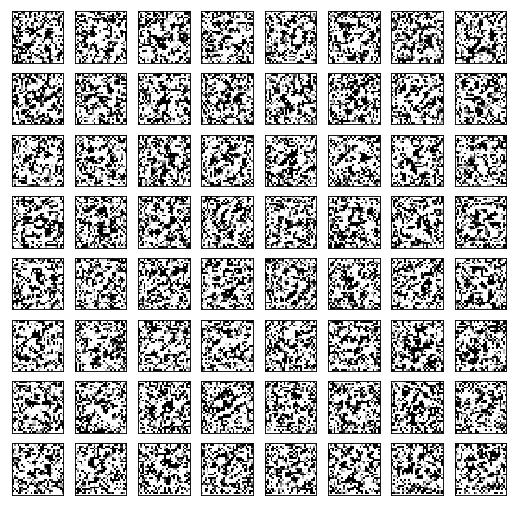

Iteration 122000: loss=5.855261406395584e-06
Iteration 124000: loss=5.844274710398167e-06
Iteration 126000: loss=5.833594059367897e-06
Iteration 128000: loss=5.823184437758755e-06
Iteration 130000: loss=5.8130126490141265e-06
Iteration 132000: loss=5.803046406072099e-06
Iteration 134000: loss=5.793232048745267e-06
Iteration 136000: loss=5.783558208349859e-06
Iteration 138000: loss=5.774027613369981e-06
Iteration 140000: loss=5.764662546425825e-06
Iteration 142000: loss=5.755485290137585e-06
Iteration 144000: loss=5.74651539864135e-06
Iteration 146000: loss=5.737760147894733e-06
Iteration 148000: loss=5.729230906581506e-06
Iteration 150000: loss=5.720913122786442e-06
Iteration 152000: loss=5.712825895898277e-06
Iteration 154000: loss=5.7049610404646955e-06
Iteration 156000: loss=5.697319465980399e-06
Iteration 158000: loss=5.689897534466581e-06
Iteration 160000: loss=5.6826957006705925e-06


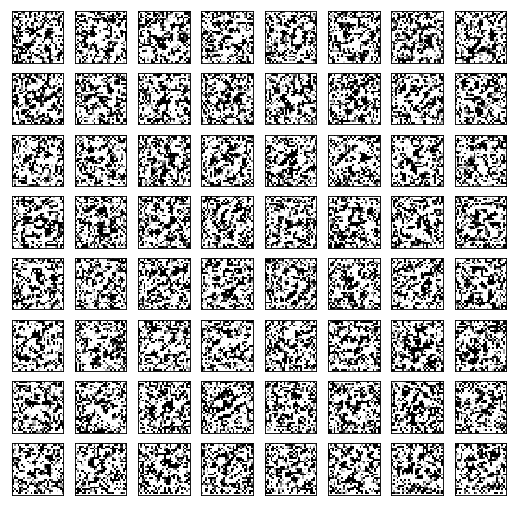

Iteration 162000: loss=5.675699867424555e-06
Iteration 164000: loss=5.668904123012908e-06
Iteration 166000: loss=5.662308922183001e-06
Iteration 168000: loss=5.655891527567292e-06
Iteration 170000: loss=5.649660124618094e-06
Iteration 172000: loss=5.643592430715216e-06
Iteration 174000: loss=5.637684353132499e-06
Iteration 176000: loss=5.631923158944119e-06
Iteration 178000: loss=5.626309302897425e-06
Iteration 180000: loss=5.620816864393419e-06
Iteration 182000: loss=5.615447207674151e-06
Iteration 184000: loss=5.6101994232449215e-06
Iteration 186000: loss=5.6050525927275885e-06
Iteration 188000: loss=5.600021268037381e-06
Iteration 190000: loss=5.595090442511719e-06
Iteration 192000: loss=5.590261480392655e-06
Iteration 194000: loss=5.585525286733173e-06
Iteration 196000: loss=5.580881861533271e-06
Iteration 198000: loss=5.5763266573194414e-06
Iteration 200000: loss=5.57186285732314e-06


Iteration 202000: loss=5.567481366597349e-06
Iteration 204000: loss=5.563179001910612e-06
Iteration 206000: loss=5.558965312957298e-06
Iteration 208000: loss=5.554824838327477e-06
Iteration 210000: loss=5.550758032768499e-06
Iteration 212000: loss=5.54677262698533e-06
Iteration 214000: loss=5.542847702599829e-06
Iteration 216000: loss=5.539005542232189e-06
Iteration 218000: loss=5.535226591746323e-06
Iteration 220000: loss=5.5315149438683875e-06
Iteration 222000: loss=5.527862867893418e-06
Iteration 224000: loss=5.524278549273731e-06
Iteration 226000: loss=5.520756076293765e-06
Iteration 228000: loss=5.517294084711466e-06
Iteration 230000: loss=5.5138875723059755e-06
Iteration 232000: loss=5.5105351748352405e-06
Iteration 234000: loss=5.507240530278068e-06
Iteration 236000: loss=5.503997726918897e-06
Iteration 238000: loss=5.500804036273621e-06
Iteration 240000: loss=5.497663096321048e-06


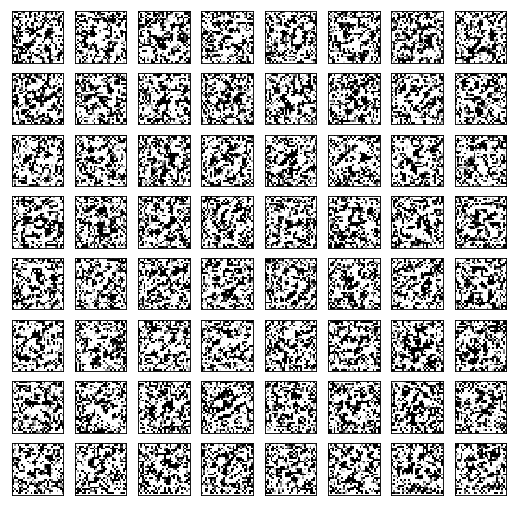

Iteration 242000: loss=5.49457581655588e-06
Iteration 244000: loss=5.49152855455759e-06
Iteration 246000: loss=5.4885299505258445e-06
Iteration 248000: loss=5.485580004460644e-06
Iteration 250000: loss=5.48267462363583e-06
Iteration 252000: loss=5.4798024393676315e-06
Iteration 254000: loss=5.476975729834521e-06
Iteration 256000: loss=5.474188128573587e-06
Iteration 258000: loss=5.47144009033218e-06
Iteration 260000: loss=5.468733434099704e-06
Iteration 262000: loss=5.466061338665895e-06
Iteration 264000: loss=5.463425168272806e-06
Iteration 266000: loss=5.460828560899245e-06
Iteration 268000: loss=5.458264240587596e-06
Iteration 270000: loss=5.455740847537527e-06
Iteration 272000: loss=5.453250196296722e-06
Iteration 274000: loss=5.450790922623128e-06
Iteration 276000: loss=5.448368938232306e-06
Iteration 278000: loss=5.445976967166644e-06
Iteration 280000: loss=5.443614554678788e-06


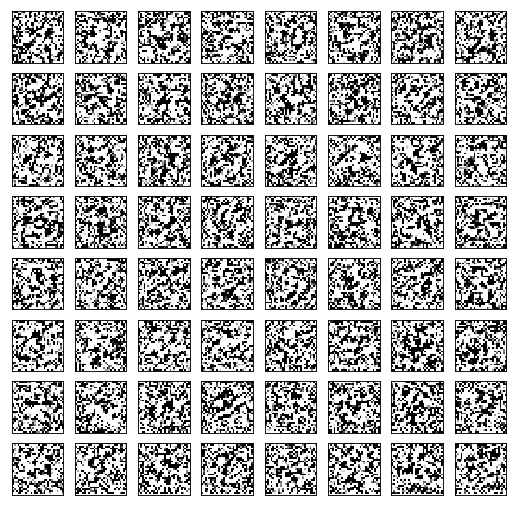

Iteration 282000: loss=5.441288067231653e-06
Iteration 284000: loss=5.438984771899413e-06
Iteration 286000: loss=5.436719220597297e-06
Iteration 288000: loss=5.4344741329259705e-06
Iteration 290000: loss=5.432265425042715e-06
Iteration 292000: loss=5.4300844567478634e-06
Iteration 294000: loss=5.4279371397569776e-06
Iteration 296000: loss=5.425807103165425e-06
Iteration 298000: loss=5.423712082119891e-06
Iteration 300000: loss=5.4216411626839545e-06
Iteration 302000: loss=5.419593890110264e-06
Iteration 304000: loss=5.417577540356433e-06
Iteration 306000: loss=5.4155771067598835e-06
Iteration 308000: loss=5.413612143456703e-06
Iteration 310000: loss=5.4116612773214e-06
Iteration 312000: loss=5.409743607742712e-06
Iteration 314000: loss=5.407840035331901e-06
Iteration 316000: loss=5.405966476246249e-06
Iteration 318000: loss=5.404112926044036e-06
Iteration 320000: loss=5.4022752919991035e-06


Iteration 322000: loss=5.400466761784628e-06
Iteration 324000: loss=5.3986746024747845e-06
Iteration 326000: loss=5.396904725785134e-06
Iteration 328000: loss=5.3951575864630286e-06
Iteration 330000: loss=5.3934277275402565e-06
Iteration 332000: loss=5.391720151237678e-06
Iteration 334000: loss=5.390029855334433e-06
Iteration 336000: loss=5.388358658819925e-06
Iteration 338000: loss=5.386708380683558e-06
Iteration 340000: loss=5.385069471230963e-06
Iteration 342000: loss=5.383455118135316e-06
Iteration 344000: loss=5.381846676755231e-06
Iteration 346000: loss=5.380265520216199e-06
Iteration 348000: loss=5.3786920943821315e-06
Iteration 350000: loss=5.377134584705345e-06
Iteration 352000: loss=5.375598448154051e-06
Iteration 354000: loss=5.374070951802423e-06
Iteration 356000: loss=5.372562554839533e-06
Iteration 358000: loss=5.3710582506028e-06
Iteration 360000: loss=5.369581685954472e-06


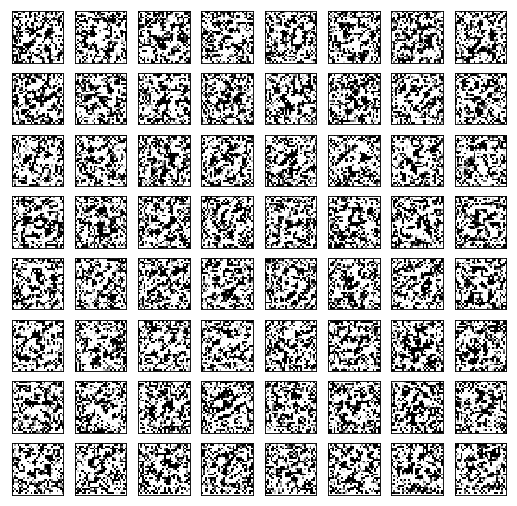

Iteration 362000: loss=5.368106940295547e-06
Iteration 364000: loss=5.366654932004167e-06
Iteration 366000: loss=5.365211109165102e-06
Iteration 368000: loss=5.36378365723067e-06
Iteration 370000: loss=5.362367119232658e-06
Iteration 372000: loss=5.360966952139279e-06
Iteration 374000: loss=5.359577698982321e-06
Iteration 376000: loss=5.3582007240038365e-06
Iteration 378000: loss=5.356838300940581e-06
Iteration 380000: loss=5.355492248781957e-06
Iteration 382000: loss=5.354152563086245e-06
Iteration 384000: loss=5.3528256103163585e-06
Iteration 386000: loss=5.351514573703753e-06
Iteration 388000: loss=5.350212632038165e-06
Iteration 390000: loss=5.348931154003367e-06
Iteration 392000: loss=5.3476546781894285e-06
Iteration 394000: loss=5.346391390048666e-06
Iteration 396000: loss=5.3451394705916755e-06
Iteration 398000: loss=5.343907560018124e-06
Iteration 400000: loss=5.342683834896889e-06


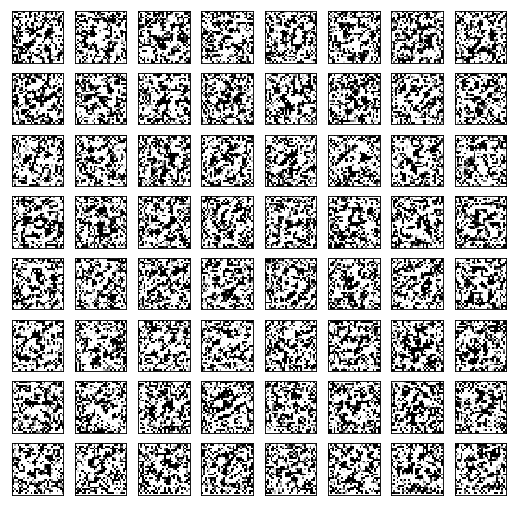

Iteration 402000: loss=5.341472842701478e-06
Iteration 404000: loss=5.340275492926594e-06
Iteration 406000: loss=5.339085873856675e-06
Iteration 408000: loss=5.337911261449335e-06
Iteration 410000: loss=5.336745743989013e-06
Iteration 412000: loss=5.335599325917428e-06
Iteration 414000: loss=5.334462457540212e-06
Iteration 416000: loss=5.333330591383856e-06
Iteration 418000: loss=5.332217824616237e-06
Iteration 420000: loss=5.331113243300933e-06
Iteration 422000: loss=5.330018211679999e-06
Iteration 424000: loss=5.328937277226942e-06
Iteration 426000: loss=5.32786407347885e-06
Iteration 428000: loss=5.326799509930424e-06
Iteration 430000: loss=5.325753136276035e-06
Iteration 432000: loss=5.324718586052768e-06
Iteration 434000: loss=5.323688128555659e-06
Iteration 436000: loss=5.322668130247621e-06
Iteration 438000: loss=5.321660864865407e-06
Iteration 440000: loss=5.3206626944302116e-06


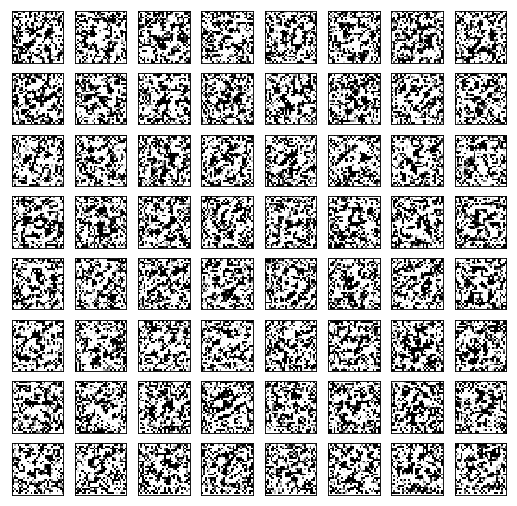

Iteration 442000: loss=5.319672254699981e-06
Iteration 444000: loss=5.318697731127031e-06
Iteration 446000: loss=5.31773275724845e-06
Iteration 448000: loss=5.3167700571066234e-06
Iteration 450000: loss=5.3158205446379725e-06
Iteration 452000: loss=5.314881491358392e-06
Iteration 454000: loss=5.3139460760576185e-06
Iteration 456000: loss=5.313029305398231e-06
Iteration 458000: loss=5.312116172717651e-06
Iteration 460000: loss=5.311208951752633e-06
Iteration 462000: loss=5.310315827955492e-06
Iteration 464000: loss=5.3094281611265615e-06
Iteration 466000: loss=5.308552317728754e-06
Iteration 468000: loss=5.307680112309754e-06
Iteration 470000: loss=5.306819275574526e-06
Iteration 472000: loss=5.305967079038965e-06
Iteration 474000: loss=5.3051221584610175e-06
Iteration 476000: loss=5.3042813306092285e-06
Iteration 478000: loss=5.303450507199159e-06
Iteration 480000: loss=5.302628778736107e-06


Iteration 482000: loss=5.3018179642094765e-06
Iteration 484000: loss=5.301002602209337e-06
Iteration 486000: loss=5.300206794345286e-06
Iteration 488000: loss=5.299407803249778e-06
Iteration 490000: loss=5.298630185279762e-06
Iteration 492000: loss=5.297847565088887e-06
Iteration 494000: loss=5.2970758588344324e-06
Iteration 496000: loss=5.296309609548189e-06
Iteration 498000: loss=5.2955497267248575e-06
Iteration 500000: loss=5.294798484101193e-06
Iteration 502000: loss=5.294047241477529e-06
Iteration 504000: loss=5.293307367537636e-06
Iteration 506000: loss=5.292576588544762e-06
Iteration 508000: loss=5.29184717379394e-06
Iteration 510000: loss=5.291125035000732e-06
Iteration 512000: loss=5.290407898428384e-06
Iteration 514000: loss=5.289696218824247e-06
Iteration 516000: loss=5.28899499840918e-06
Iteration 518000: loss=5.288291504257359e-06
Iteration 520000: loss=5.287595740810502e-06


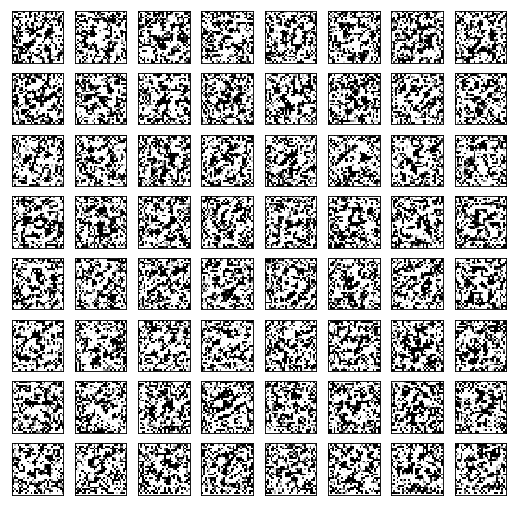

Iteration 522000: loss=5.286908617563313e-06
Iteration 524000: loss=5.286223768052878e-06
Iteration 526000: loss=5.285547103994759e-06
Iteration 528000: loss=5.284872258926043e-06
Iteration 530000: loss=5.284206963551696e-06
Iteration 532000: loss=5.2835416681773495e-06
Iteration 534000: loss=5.2828845582553186e-06
Iteration 536000: loss=5.2822319958067965e-06
Iteration 538000: loss=5.281583980831783e-06
Iteration 540000: loss=5.280935056362068e-06
Iteration 542000: loss=5.280295226839371e-06
Iteration 544000: loss=5.279659944790183e-06
Iteration 546000: loss=5.279028755467152e-06
Iteration 548000: loss=5.2784030231123324e-06
Iteration 550000: loss=5.277774562273407e-06
Iteration 552000: loss=5.2771533773920964e-06
Iteration 554000: loss=5.276535375742242e-06
Iteration 556000: loss=5.275924650050001e-06
Iteration 558000: loss=5.275318017083919e-06
Iteration 560000: loss=5.274714567349292e-06


Iteration 562000: loss=5.274112481856719e-06
Iteration 564000: loss=5.27351812706911e-06
Iteration 566000: loss=5.272916496323887e-06
Iteration 568000: loss=5.2723266890097875e-06
Iteration 570000: loss=5.271739155432442e-06
Iteration 572000: loss=5.271154805086553e-06
Iteration 574000: loss=5.270570454740664e-06
Iteration 576000: loss=5.269990197120933e-06
Iteration 578000: loss=5.2694149417220615e-06
Iteration 580000: loss=5.268838776828488e-06
Iteration 582000: loss=5.268267614155775e-06
Iteration 584000: loss=5.267699179967167e-06
Iteration 586000: loss=5.267130745778559e-06
Iteration 588000: loss=5.266566404316109e-06
Iteration 590000: loss=5.266001608106308e-06
Iteration 592000: loss=5.2654459068435244e-06
Iteration 594000: loss=5.2648847486125305e-06
Iteration 596000: loss=5.264331775833853e-06
Iteration 598000: loss=5.263784714770736e-06
Iteration 600000: loss=5.263231287244707e-06


Iteration 602000: loss=5.26268377143424e-06
Iteration 604000: loss=5.262142167339334e-06
Iteration 606000: loss=5.261595561023569e-06
Iteration 608000: loss=5.261049864202505e-06
Iteration 610000: loss=5.260512807581108e-06
Iteration 612000: loss=5.259973477222957e-06
Iteration 614000: loss=5.259440968075069e-06
Iteration 616000: loss=5.258911642158637e-06
Iteration 618000: loss=5.2583795877581e-06
Iteration 620000: loss=5.257848442852264e-06
Iteration 622000: loss=5.2573191169358324e-06
Iteration 624000: loss=5.256793428998208e-06
Iteration 626000: loss=5.256270469544688e-06
Iteration 628000: loss=5.255748419585871e-06
Iteration 630000: loss=5.255229552858509e-06
Iteration 632000: loss=5.2547120503732e-06
Iteration 634000: loss=5.254196821624646e-06
Iteration 636000: loss=5.25368568560225e-06
Iteration 638000: loss=5.253170456853695e-06
Iteration 640000: loss=5.252663413557457e-06


Iteration 642000: loss=5.252157734503271e-06
Iteration 644000: loss=5.25164932696498e-06
Iteration 646000: loss=5.2511468311422504e-06
Iteration 648000: loss=5.250644335319521e-06
Iteration 650000: loss=5.250144113233546e-06
Iteration 652000: loss=5.2496443458949216e-06
Iteration 654000: loss=5.249143214314245e-06
Iteration 656000: loss=5.248645265965024e-06
Iteration 658000: loss=5.2481505008472595e-06
Iteration 660000: loss=5.247655735729495e-06
Iteration 662000: loss=5.247164608590538e-06
Iteration 664000: loss=5.246677574177738e-06
Iteration 666000: loss=5.246189630270237e-06
Iteration 668000: loss=5.245701686362736e-06
Iteration 670000: loss=5.245220108918147e-06
Iteration 672000: loss=5.2447344387474e-06
Iteration 674000: loss=5.244250587566057e-06
Iteration 676000: loss=5.243770374363521e-06
Iteration 678000: loss=5.243294708634494e-06
Iteration 680000: loss=5.242814040684607e-06


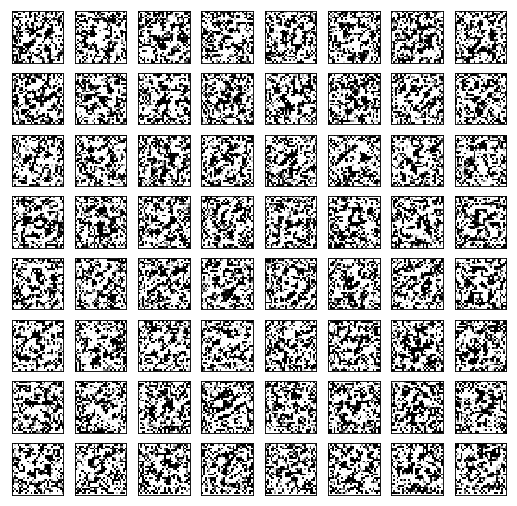

Iteration 682000: loss=5.2423347369767725e-06
Iteration 684000: loss=5.241858616500394e-06
Iteration 686000: loss=5.241377039055806e-06
Iteration 688000: loss=5.240906375547638e-06
Iteration 690000: loss=5.240437985776225e-06
Iteration 692000: loss=5.239964139036601e-06
Iteration 694000: loss=5.239496204012539e-06
Iteration 696000: loss=5.239025995251723e-06
Iteration 698000: loss=5.2385576054803096e-06
Iteration 700000: loss=5.238092398940353e-06
Iteration 702000: loss=5.2376285566424485e-06
Iteration 704000: loss=5.237165623839246e-06
Iteration 706000: loss=5.2367076932569034e-06
Iteration 708000: loss=5.236241122474894e-06
Iteration 710000: loss=5.2357863751240075e-06
Iteration 712000: loss=5.2353298087837175e-06
Iteration 714000: loss=5.23487960890634e-06
Iteration 716000: loss=5.234422587818699e-06
Iteration 718000: loss=5.233978754404234e-06
Iteration 720000: loss=5.233529009274207e-06


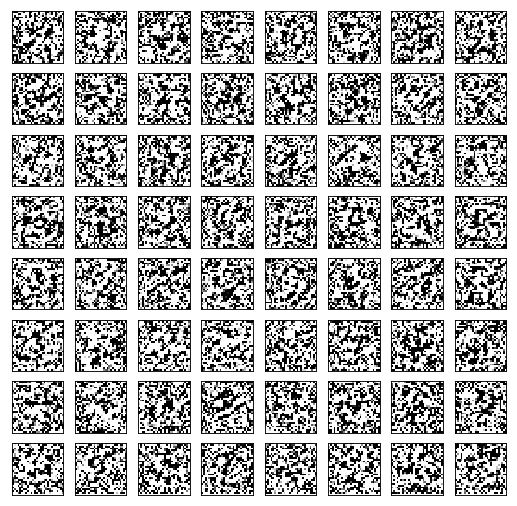

Iteration 722000: loss=5.233085175859742e-06
Iteration 724000: loss=5.2326417971926276e-06
Iteration 726000: loss=5.23220205650432e-06
Iteration 728000: loss=5.2317686822789256e-06
Iteration 730000: loss=5.23133485330618e-06
Iteration 732000: loss=5.230906026554294e-06
Iteration 734000: loss=5.230472197581548e-06
Iteration 736000: loss=5.230042916082311e-06
Iteration 738000: loss=5.2296259127615485e-06
Iteration 740000: loss=5.2292057262093294e-06
Iteration 742000: loss=5.228790996625321e-06
Iteration 744000: loss=5.228370355325751e-06
Iteration 746000: loss=5.227958808973199e-06
Iteration 748000: loss=5.22754908161005e-06
Iteration 750000: loss=5.227141173236305e-06
Iteration 752000: loss=5.226735083851963e-06
Iteration 754000: loss=5.226334906183183e-06
Iteration 756000: loss=5.225935638009105e-06
Iteration 758000: loss=5.2255363698350266e-06
Iteration 760000: loss=5.2251443776185624e-06


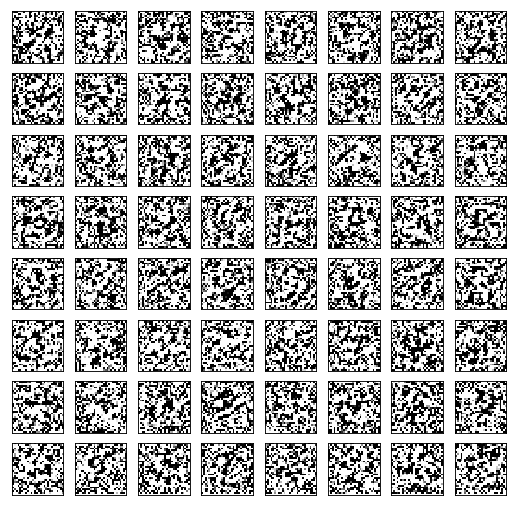

Iteration 762000: loss=5.224752385402098e-06
Iteration 764000: loss=5.224364940659143e-06
Iteration 766000: loss=5.223975676926784e-06
Iteration 768000: loss=5.223593234404689e-06
Iteration 770000: loss=5.223212156124646e-06
Iteration 772000: loss=5.2228288041078486e-06
Iteration 774000: loss=5.222449090069858e-06
Iteration 776000: loss=5.222071649768623e-06
Iteration 778000: loss=5.22170103067765e-06
Iteration 780000: loss=5.2213308663340285e-06
Iteration 782000: loss=5.220956609264249e-06
Iteration 784000: loss=5.220590992394136e-06
Iteration 786000: loss=5.220223101787269e-06
Iteration 788000: loss=5.2198570301698055e-06
Iteration 790000: loss=5.219499598752009e-06
Iteration 792000: loss=5.2191403483448084e-06
Iteration 794000: loss=5.21877700521145e-06
Iteration 796000: loss=5.21842275702511e-06
Iteration 798000: loss=5.218065325607313e-06
Iteration 800000: loss=5.217712896410376e-06


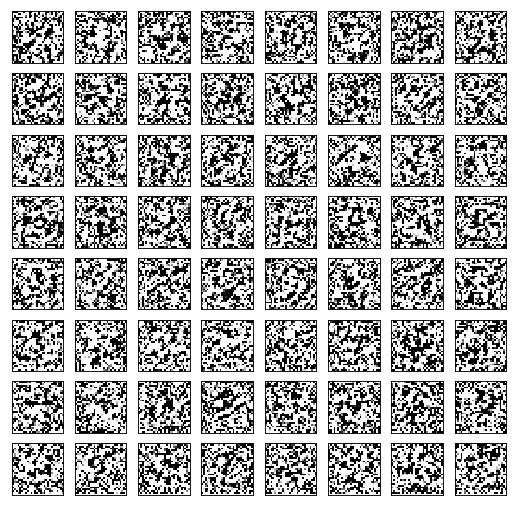

Iteration 802000: loss=5.217356829234632e-06
Iteration 804000: loss=5.2170071285218e-06
Iteration 806000: loss=5.216656063566916e-06
Iteration 808000: loss=5.216313184064347e-06
Iteration 810000: loss=5.215961209614761e-06
Iteration 812000: loss=5.215621058596298e-06
Iteration 814000: loss=5.2152709031361155e-06
Iteration 816000: loss=5.214926204644144e-06
Iteration 818000: loss=5.214586963120382e-06
Iteration 820000: loss=5.214244083617814e-06
Iteration 822000: loss=5.213902113609947e-06
Iteration 824000: loss=5.213558779360028e-06
Iteration 826000: loss=5.213223175815074e-06
Iteration 828000: loss=5.21288257004926e-06
Iteration 830000: loss=5.212549694988411e-06
Iteration 832000: loss=5.212212272454053e-06
Iteration 834000: loss=5.211875304667046e-06
Iteration 836000: loss=5.211544248595601e-06
Iteration 838000: loss=5.211209099797998e-06
Iteration 840000: loss=5.210872586758342e-06


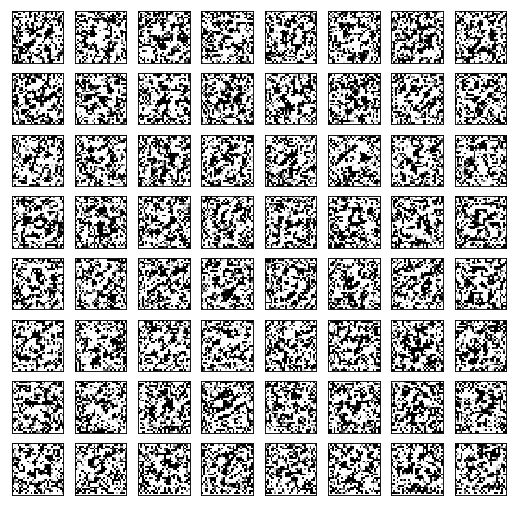

Iteration 842000: loss=5.210538802202791e-06
Iteration 844000: loss=5.210206836636644e-06
Iteration 846000: loss=5.2098757805651985e-06
Iteration 848000: loss=5.209543814999051e-06
Iteration 850000: loss=5.20921457791701e-06
Iteration 852000: loss=5.2088826123508625e-06
Iteration 854000: loss=5.2085542847635224e-06
Iteration 856000: loss=5.2082295951549895e-06
Iteration 858000: loss=5.207901722315e-06
Iteration 860000: loss=5.207571575738257e-06
Iteration 862000: loss=5.207247795624426e-06
Iteration 864000: loss=5.206925379752647e-06
Iteration 866000: loss=5.206601599638816e-06
Iteration 868000: loss=5.2062832764931954e-06
Iteration 870000: loss=5.2059704103157856e-06
Iteration 872000: loss=5.205649813433411e-06
Iteration 874000: loss=5.205331035540439e-06
Iteration 876000: loss=5.20501862411038e-06
Iteration 878000: loss=5.204707576922374e-06
Iteration 880000: loss=5.204393346502911e-06


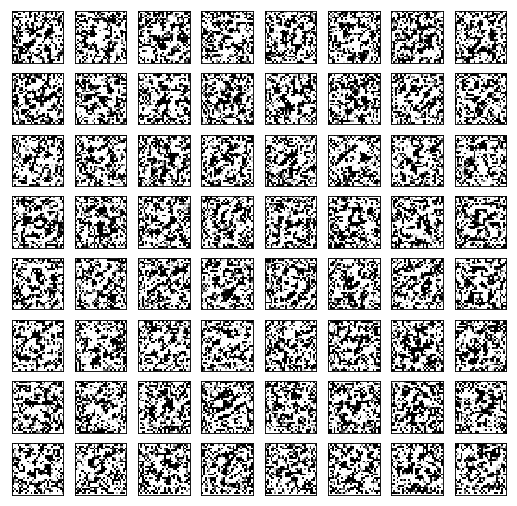

Iteration 882000: loss=5.204087301535765e-06
Iteration 884000: loss=5.203778073337162e-06
Iteration 886000: loss=5.20346929988591e-06
Iteration 888000: loss=5.20316643815022e-06
Iteration 890000: loss=5.202865850151284e-06
Iteration 892000: loss=5.202565262152348e-06
Iteration 894000: loss=5.202266493142815e-06
Iteration 896000: loss=5.201975454838248e-06
Iteration 898000: loss=5.201688509259839e-06
Iteration 900000: loss=5.2013924687344115e-06
Iteration 902000: loss=5.201105977903353e-06
Iteration 904000: loss=5.200816303840838e-06
Iteration 906000: loss=5.200534360483289e-06
Iteration 908000: loss=5.200252417125739e-06
Iteration 910000: loss=5.199969564273488e-06
Iteration 912000: loss=5.199693077884149e-06
Iteration 914000: loss=5.1994097702845465e-06
Iteration 916000: loss=5.199135557631962e-06
Iteration 918000: loss=5.198859525989974e-06
Iteration 920000: loss=5.198588041821495e-06


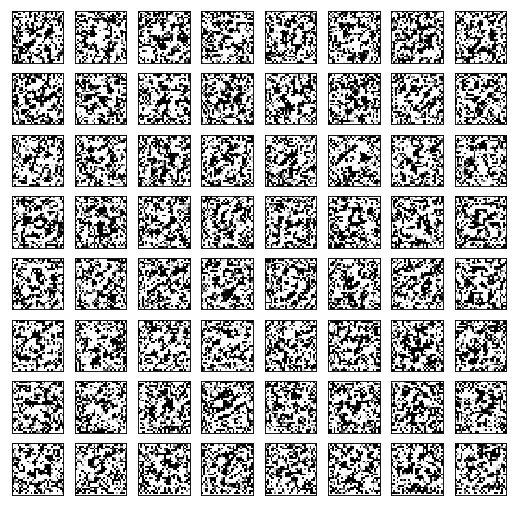

Iteration 922000: loss=5.198321559873875e-06
Iteration 924000: loss=5.198049166210694e-06
Iteration 926000: loss=5.197783139010426e-06
Iteration 928000: loss=5.19751347383135e-06
Iteration 930000: loss=5.197256086830748e-06
Iteration 932000: loss=5.196988695388427e-06
Iteration 934000: loss=5.19672857990372e-06
Iteration 936000: loss=5.196468009671662e-06
Iteration 938000: loss=5.196207894186955e-06
Iteration 940000: loss=5.195951871428406e-06
Iteration 942000: loss=5.195695393922506e-06
Iteration 944000: loss=5.195442554395413e-06
Iteration 946000: loss=5.195181529416004e-06
Iteration 948000: loss=5.194929599383613e-06
Iteration 950000: loss=5.1946794883406255e-06
Iteration 952000: loss=5.1944311962870415e-06
Iteration 954000: loss=5.194181085244054e-06
Iteration 956000: loss=5.193931883695768e-06
Iteration 958000: loss=5.193683591642184e-06
Iteration 960000: loss=5.193433025851846e-06


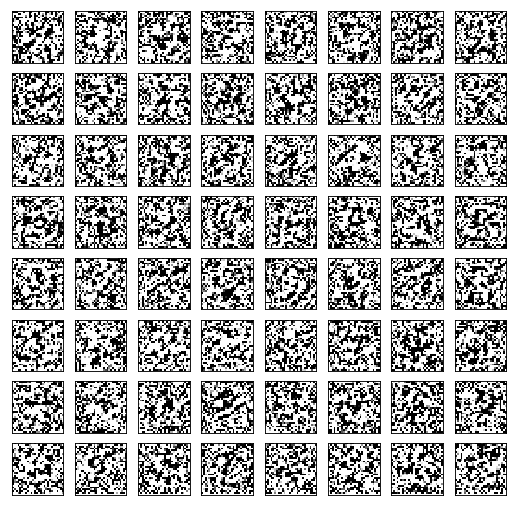

Iteration 962000: loss=5.193192009755876e-06
Iteration 964000: loss=5.192944627196994e-06
Iteration 966000: loss=5.1927008826169185e-06
Iteration 968000: loss=5.192455773794791e-06
Iteration 970000: loss=5.192213848204119e-06
Iteration 972000: loss=5.191973741602851e-06
Iteration 974000: loss=5.191728632780723e-06
Iteration 976000: loss=5.191486252442701e-06
Iteration 978000: loss=5.191251602809643e-06
Iteration 980000: loss=5.191011950955726e-06
Iteration 982000: loss=5.190769570617704e-06
Iteration 984000: loss=5.190530828258488e-06
Iteration 986000: loss=5.190298452362185e-06
Iteration 988000: loss=5.1900574362662155e-06
Iteration 990000: loss=5.189818239159649e-06
Iteration 992000: loss=5.189582225284539e-06
Iteration 994000: loss=5.1893484851461835e-06
Iteration 996000: loss=5.189114290260477e-06
Iteration 998000: loss=5.188871000427753e-06
Iteration 1000000: loss=5.188641353015555e-06


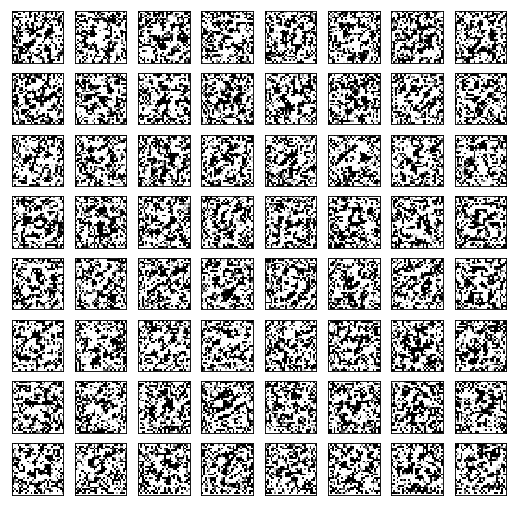

In [27]:
new_image_randn = generate_image(img)

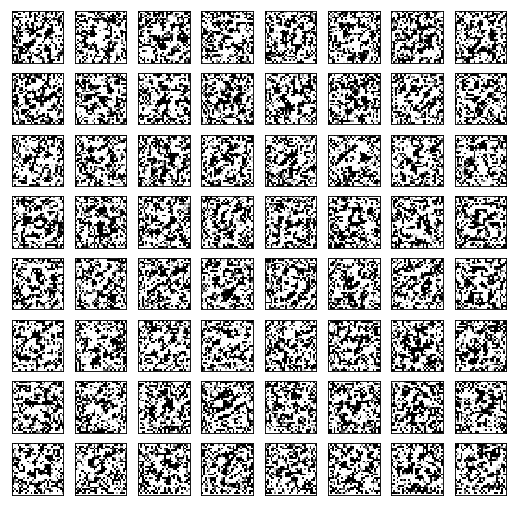

In [28]:
to_plot = new_image_randn.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (8, 8))

Преобразуем сгенерированные изображения с помощью энкодера - на выходе получается матрица, близкая к единичной.

In [29]:
latent = model.E(new_image_randn.view(-1, 28*28))
print (latent.shape)
print (latent)

torch.Size([64, 64])
tensor([[ 9.8398e-01, -6.9350e-05,  8.8848e-05,  ...,  4.2334e-05,
          9.3170e-06,  1.4418e-04],
        [-7.1093e-05,  9.8256e-01, -1.2666e-05,  ..., -7.0937e-05,
          2.5690e-05,  5.2378e-05],
        [ 1.1592e-04, -2.3481e-05,  9.8605e-01,  ..., -2.8454e-05,
          3.7342e-05,  2.7835e-05],
        ...,
        [ 1.2115e-05, -5.0366e-05, -4.5612e-05,  ...,  9.8697e-01,
          3.3468e-05,  5.0426e-05],
        [ 2.5168e-05, -2.4676e-05,  8.2105e-06,  ..., -4.4465e-05,
          9.8272e-01, -7.4334e-05],
        [ 6.6578e-05,  2.8566e-05, -1.2490e-04,  ...,  5.8651e-05,
         -5.3018e-05,  9.8335e-01]])


Сравним сгенерированные изображения с выходом декодера

tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1])


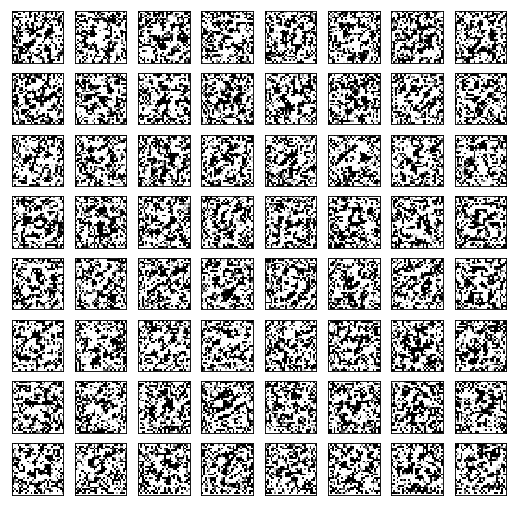

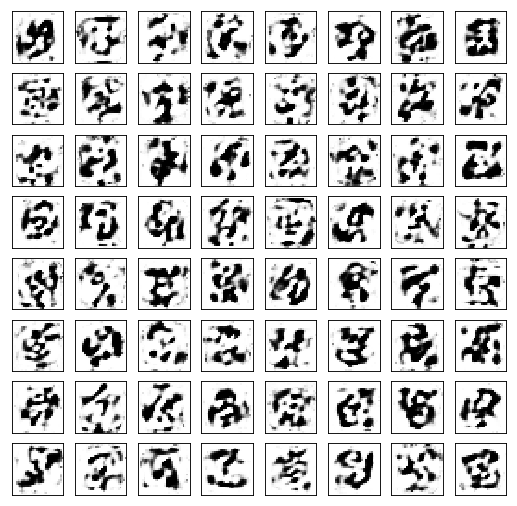

In [30]:
to_plot = new_image_randn.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()

with torch.no_grad():
    encoded = model.E(new_image_randn.view(-1, 28*28))
    print((encoded > 0.2).sum(1))
    encoded[encoded < 0.2] = 0.
    decoded_f = model.decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

plot_mnist(to_plot, (8, 8))
plot_mnist(f_to_plot, (8, 8)) 